# Aleatoric Uncertainty

## Generate Fake Regression Dataset with one Feature

#### Train set


This is a heteroscedastic dataset (variance changes for samples).

In the following we want to estimate the variance based on the training data (conditioned on the inputs).

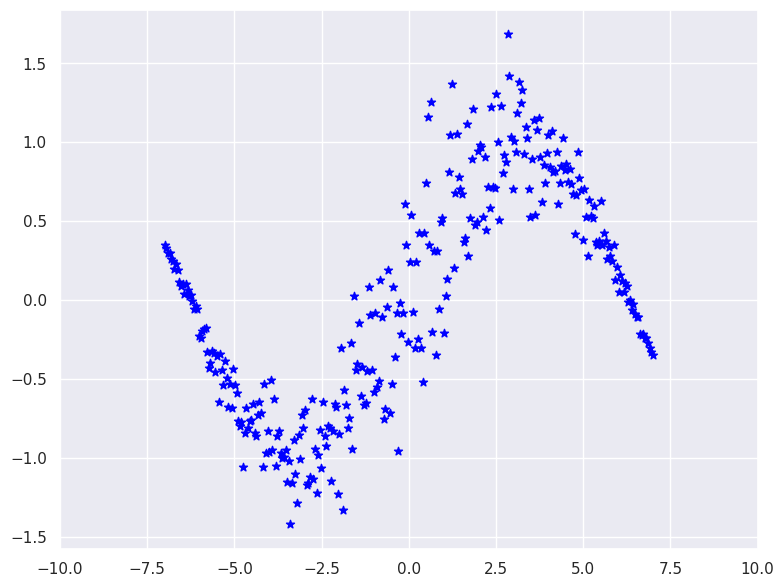

In [25]:
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
import math
import numpy as np
figure(figsize=(9, 7))

# Same range for all plots
plt.xlim([-10, 10])
start = -7
end = 7
n = 300

def sample_dataset(start, end, n):
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs()
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

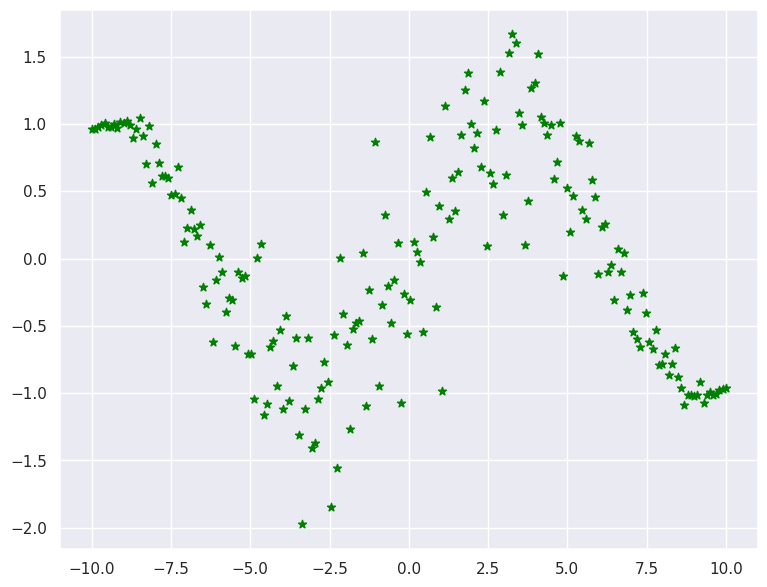

In [26]:
figure(figsize=(9, 7))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

Put data into Tensor Datasets

In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Maximum likelihood Estimation

### Simple Neural Network that predicts mean and variance
- We output variance here, because our loss function expects var = sigma**2 (instead of just sigma)
- We could also use just one Linear output layer with 2 neurons

In [28]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 64

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mu = self.mu(h)
        # Exponential activation to enforce positive var
        var = torch.exp(self.var(h))
        return mu, var

net = SimpleNet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=1, bias=True)
  (var): Linear(in_features=64, out_features=1, bias=True)
)
Params: 4418


In [29]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(9, 7)})

def make_plot(model):
    # Get predictions
    mu, var = model(tensor_x_test)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()

### Train

- There are different variants for the loss. We will simply use the in pytorch already implemented [Gaussian Negative Log Likelihood](https://pytorch.org/docs/stable/generated/torch.nn.GaussianNLLLoss.html)
- The standard NLL Loss is only suited for classification problems
- [Implementation details here](https://towardsdatascience.com/knowing-known-unknowns-with-deep-neural-networks-caac1c4c1f5d)
- Another approach is to sample from the Gaussian distribution that is defined by mju/sigma and use MSE
- If we train too long it starts to overfit on the train data

Epoch 0 | batch train loss: 0.051661595702171326 | test loss: 0.36546053278904694


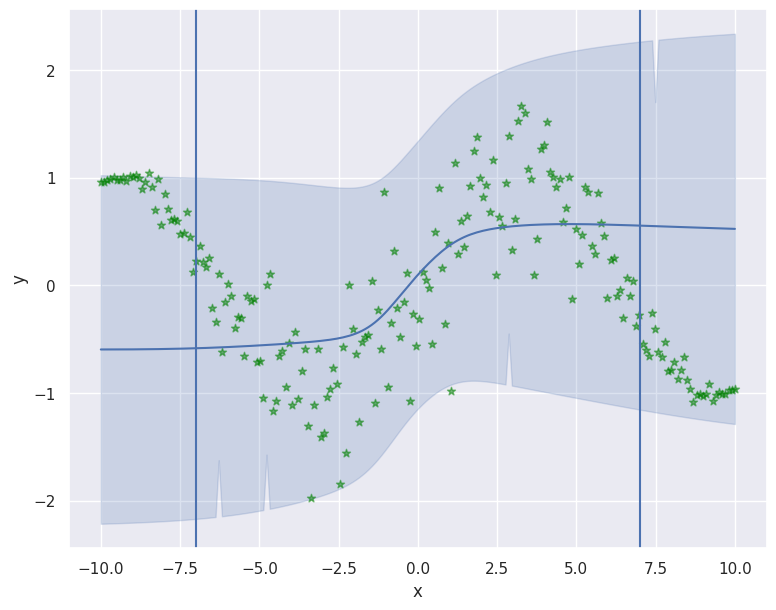

Epoch 10 | batch train loss: -0.8121955990791321 | test loss: -0.061900804249139935


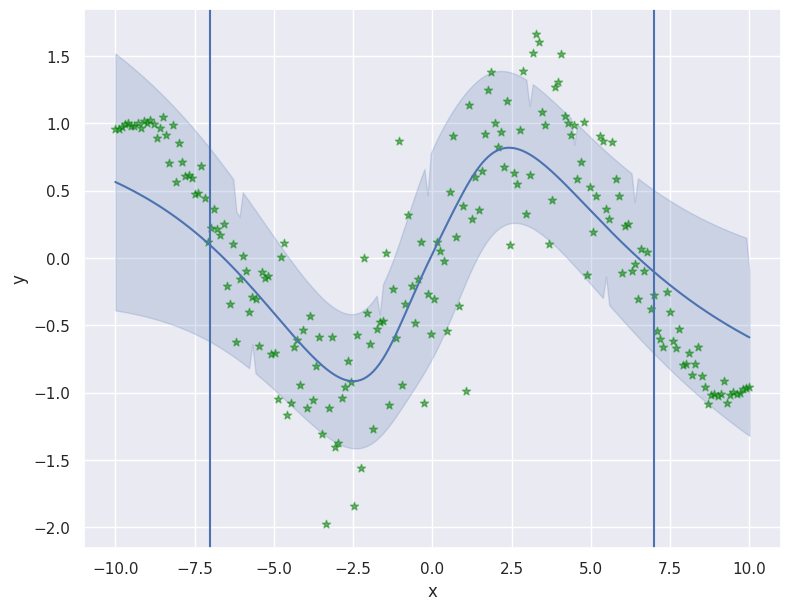

Epoch 20 | batch train loss: -0.9889228940010071 | test loss: -0.2957757550936479


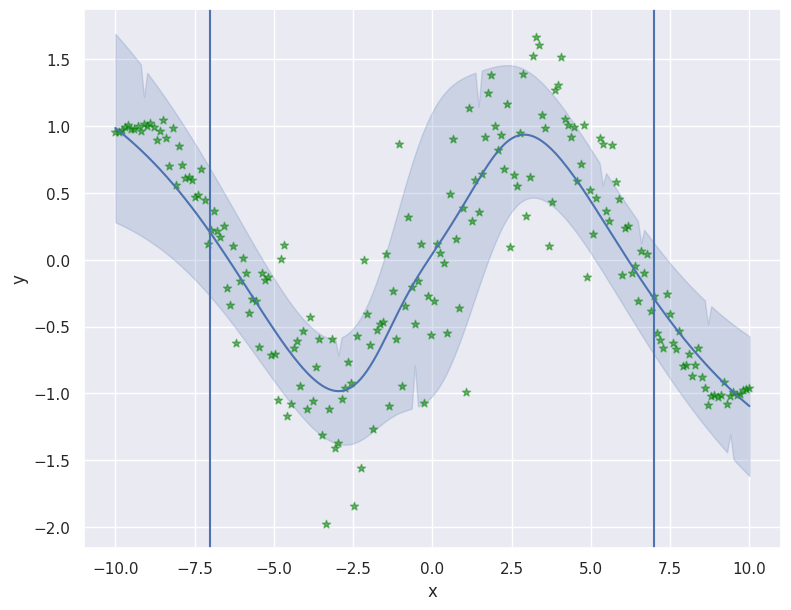

Epoch 30 | batch train loss: -1.1772180795669556 | test loss: -0.11425266300256436


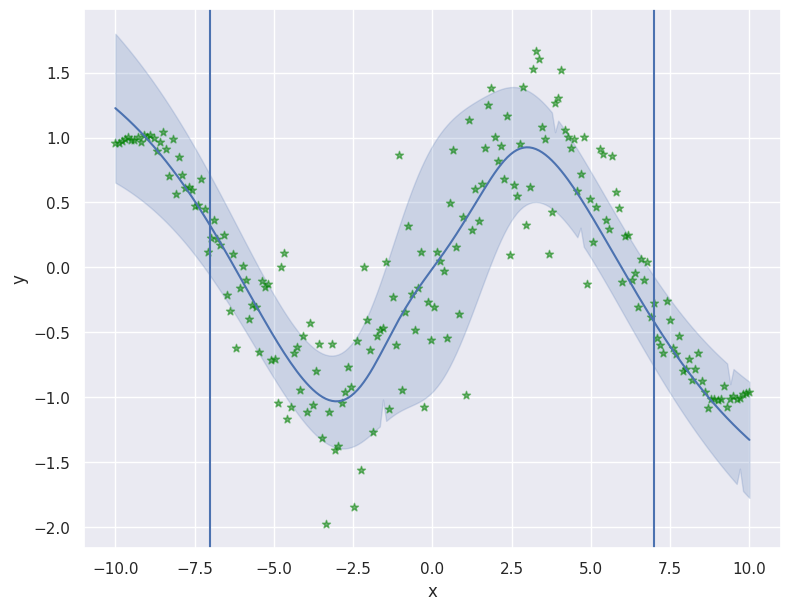

Epoch 40 | batch train loss: -1.0087915658950806 | test loss: 0.06139496656564566


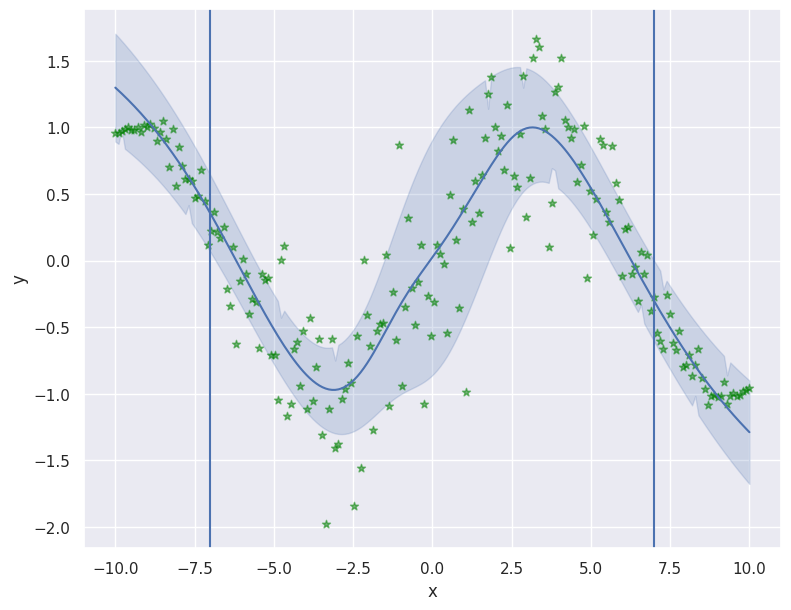

Epoch 50 | batch train loss: -1.2873822450637817 | test loss: -0.044326107089336104


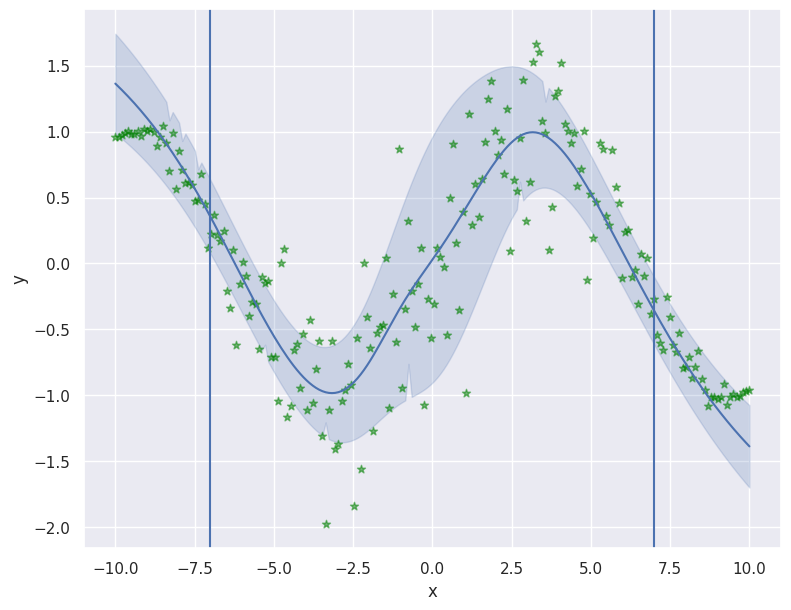

Epoch 60 | batch train loss: -1.4434667825698853 | test loss: -0.06593532774310845


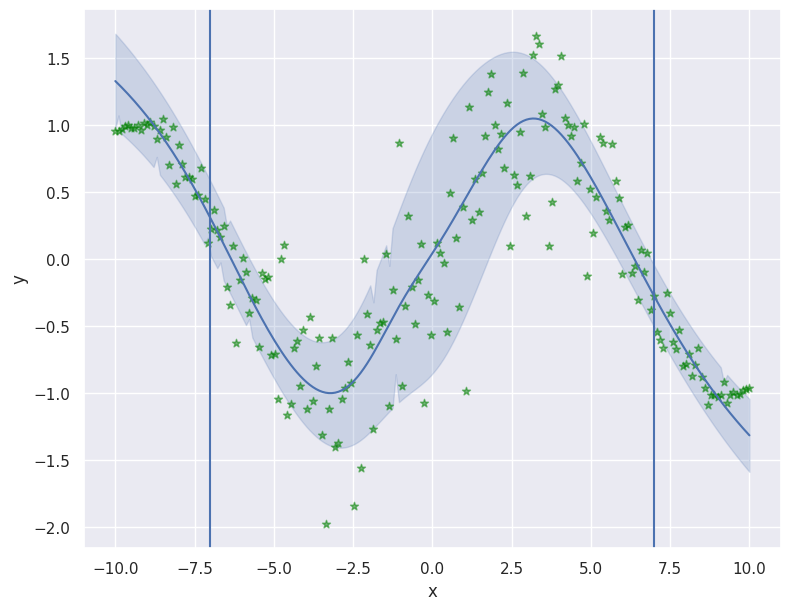

Epoch 70 | batch train loss: -0.8707879185676575 | test loss: 0.051395464401978716


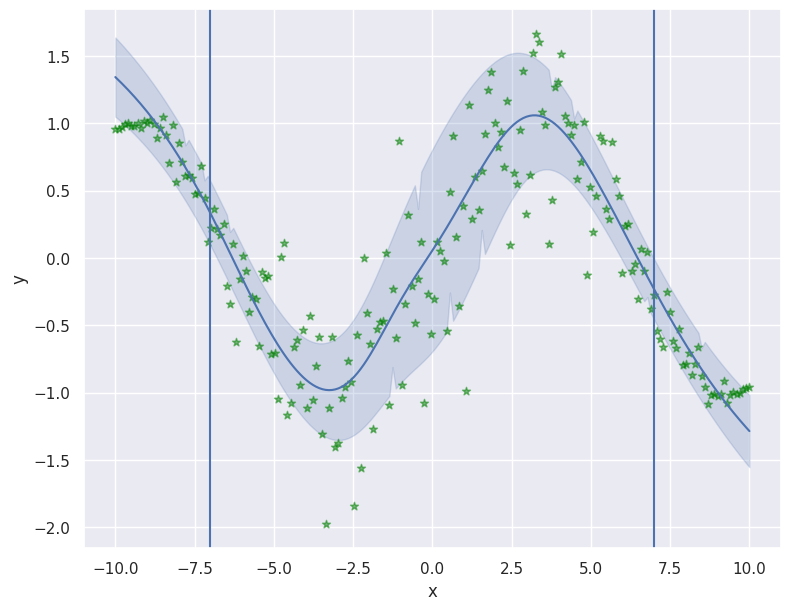

Epoch 80 | batch train loss: -0.9596651196479797 | test loss: 0.2257997691631317


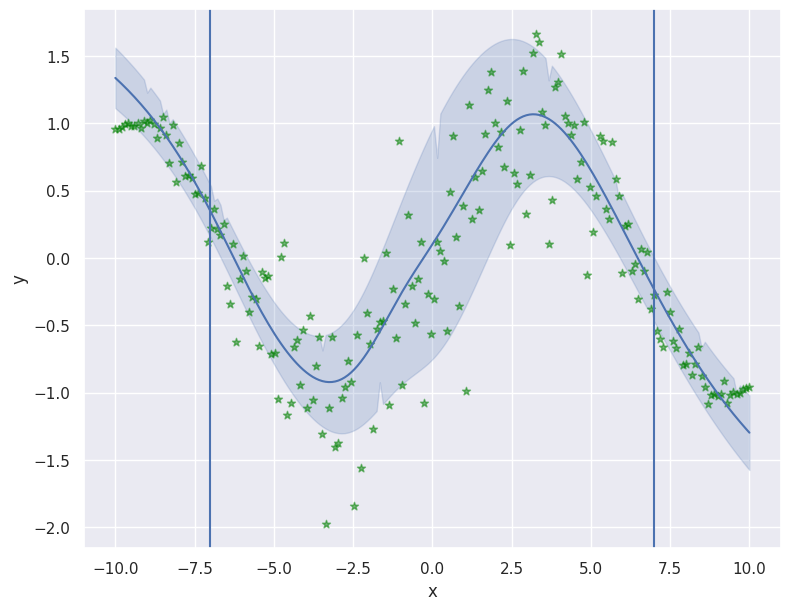

Epoch 90 | batch train loss: -1.3956457376480103 | test loss: 0.20742706725230584


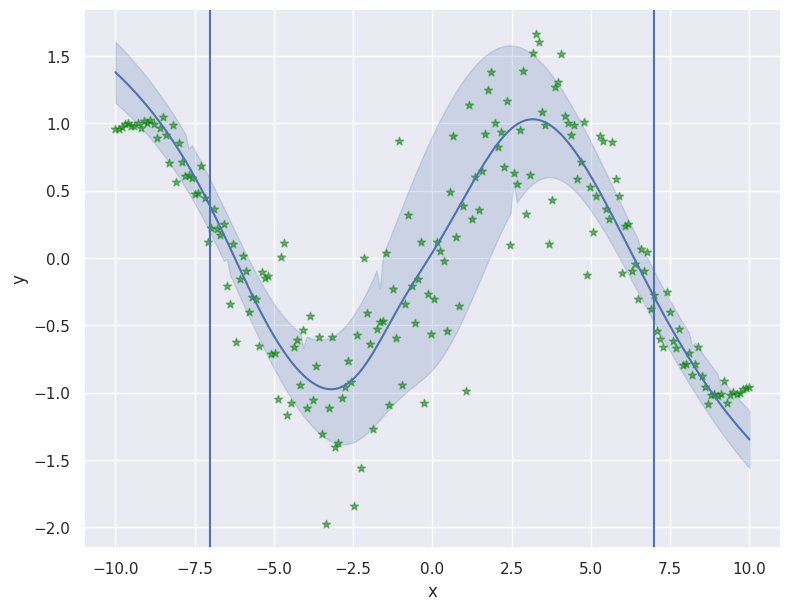

Epoch 100 | batch train loss: -0.6798367500305176 | test loss: 0.22918220666738656


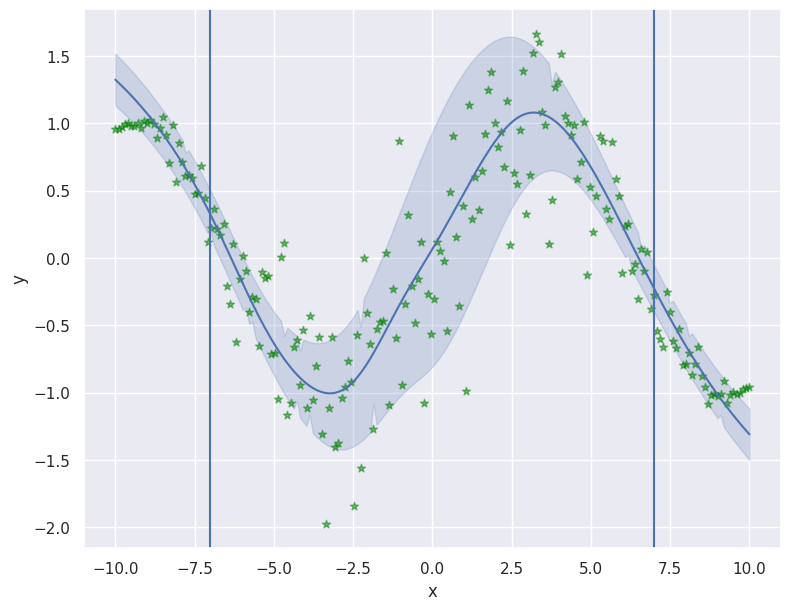

Epoch 110 | batch train loss: -1.021794319152832 | test loss: 0.2708695977926254


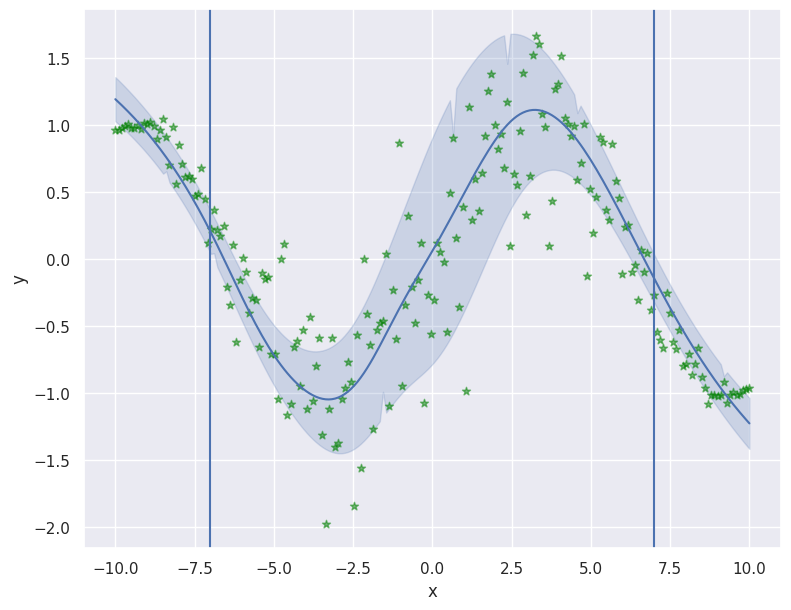

Epoch 120 | batch train loss: -1.439831256866455 | test loss: 0.20923301462943739


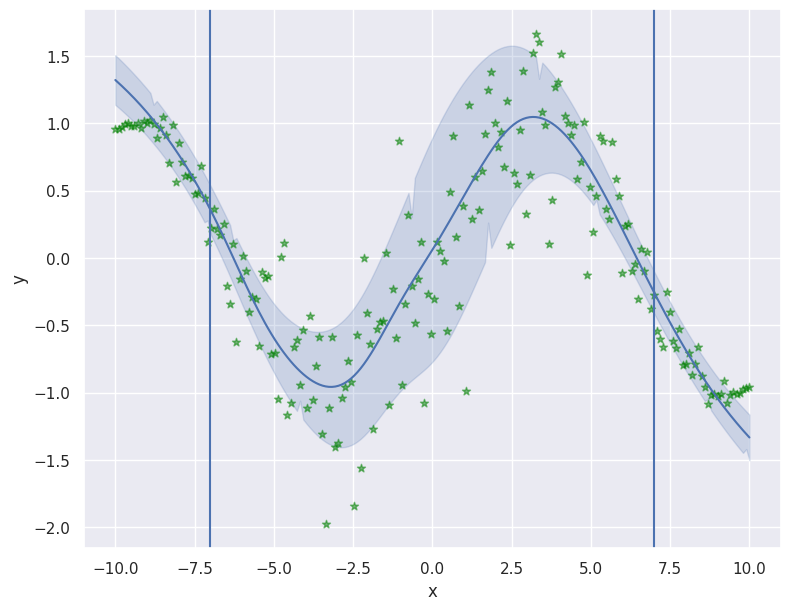

Epoch 130 | batch train loss: -0.9277438521385193 | test loss: 0.33531733888846177


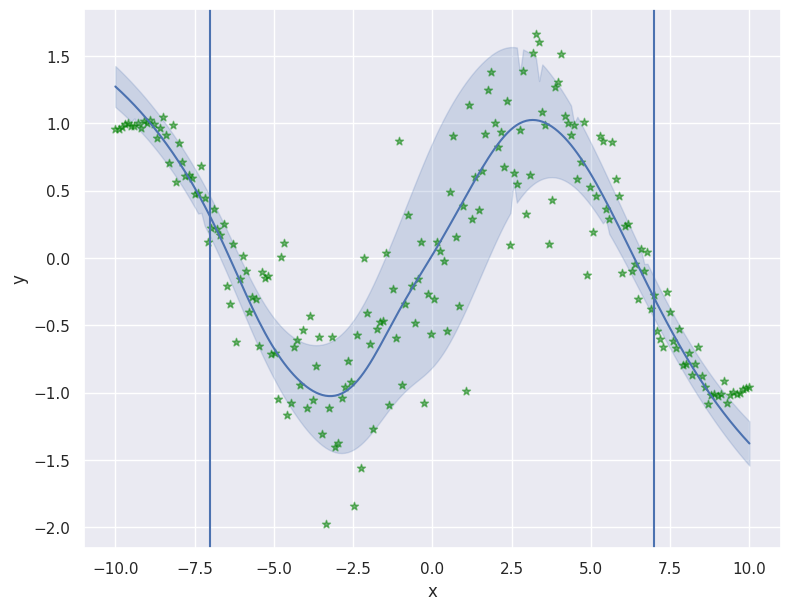

Epoch 140 | batch train loss: -1.4932631254196167 | test loss: 0.4575614367540066


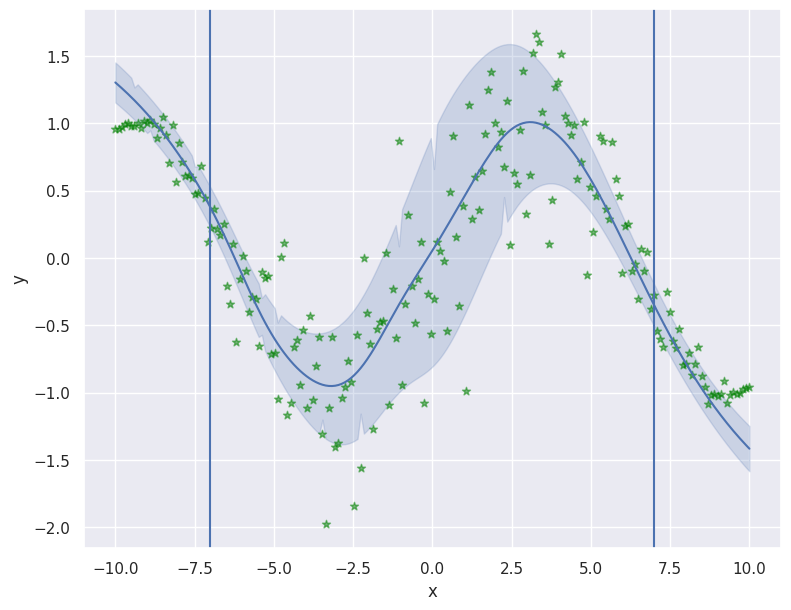

In [30]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
net.to(device)
for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot(net)

## Mixture Density Network (also MLE)

- Great implementations can be found [here](https://deep-and-shallow.com/2021/03/20/mixture-density-networks-probabilistic-regression-for-uncertainty-estimation/) and [here](https://gitlab.cs.fau.de/oc81adow/pytorch-mdn/-/blob/master/mdn/mdn.py)
- Applying a MDN doesn't make too much sense for our dataset, as we have simple gaussian variance (an not for example multimodal)
- If you don't know how the uncertainty of the target variable is distributed, using a MDN can be very helpful





In [31]:
class MDN(nn.Module):
    def __init__(self):
        super(MDN, self).__init__()
        hidden_size = 64
        self.num_gaussians = 3

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, self.num_gaussians)
        self.sigma = nn.Linear(hidden_size, self.num_gaussians)
        self.alpha = nn.Linear(hidden_size, self.num_gaussians)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mus = self.mu(h)
        sigmas = torch.exp(self.sigma(h))
        alphas = F.softmax(self.alpha(h), dim=1)
        return mus, sigmas, alphas
mdn = MDN()

In [32]:
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions import Categorical, Normal

def make_plot_mdn(model):
    # Get predictions
    mus, sigmas, alphas = model(tensor_x_test)

    # Define distribution with these parameters
    gmm = MixtureSameFamily(
            mixture_distribution=Categorical(probs=alphas),
            component_distribution=Normal(
                loc=mus,
                scale=sigmas))
    mean = gmm.mean.detach().numpy()
    var = gmm.variance.detach().numpy()


    y_vals = [mean, mean+2*var**(1/2), mean-2*var**(1/2)]
    dfs = []

    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot means
    for i in range(model.num_gaussians):
        scatter(x_test, mus[:, i].detach().numpy(), alpha=0.3, s=4)

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    plt.axvline(x=start)
    plt.axvline(x=end)
    scatter(x_test, y_test, c="green", marker="*", alpha=0.3)
    plt.show()

Loss function from [here](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca) adjusted to Pytorch.

In [33]:
def mdn_loss(mu, y, sigma, alphas):
    gmm = MixtureSameFamily(
            mixture_distribution=Categorical(probs=alphas),
            component_distribution=Normal(
                loc=mu,
                scale=sigma))
    log_likelihood = gmm.log_prob(y.t())
    return -torch.mean(log_likelihood, axis=1)

Epoch 0 | batch train loss: 0.7411878108978271 | test loss: 1.4342572964154756


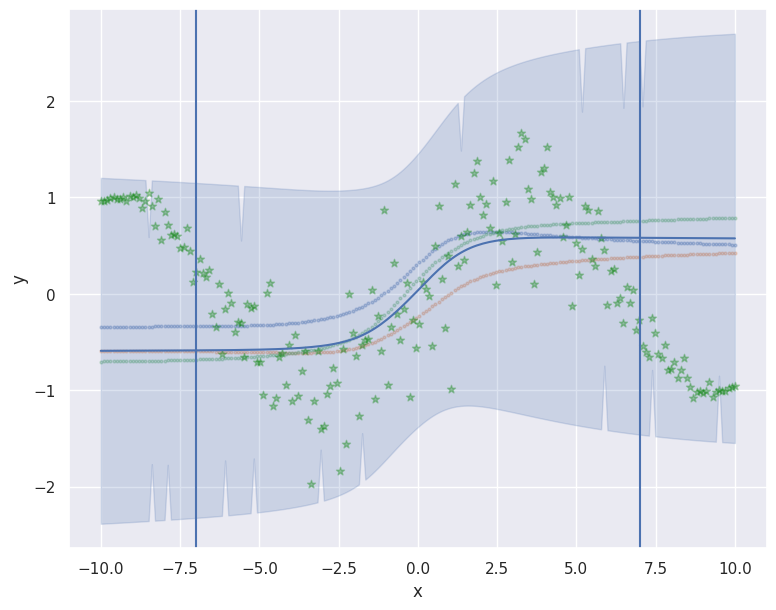

Epoch 10 | batch train loss: 0.025632688775658607 | test loss: 1.4042039972085218


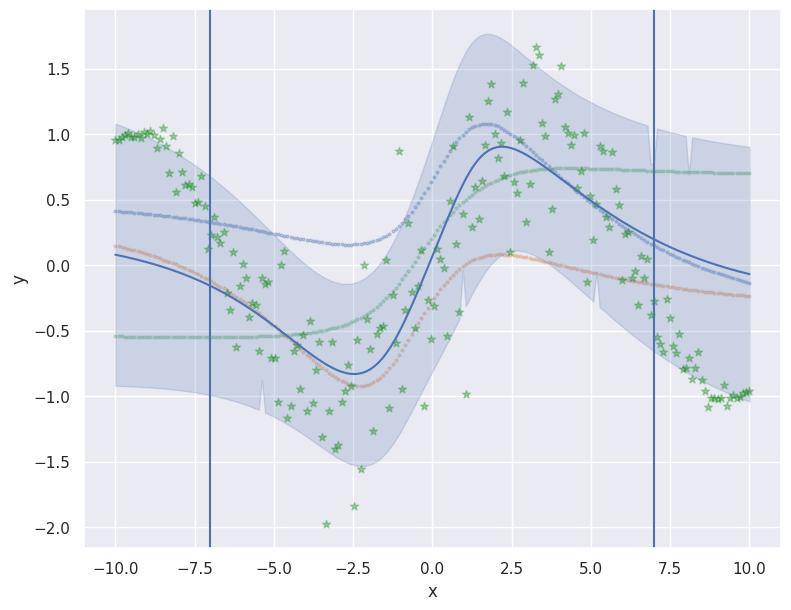

Epoch 20 | batch train loss: -0.2392902821302414 | test loss: 1.0505502292743096


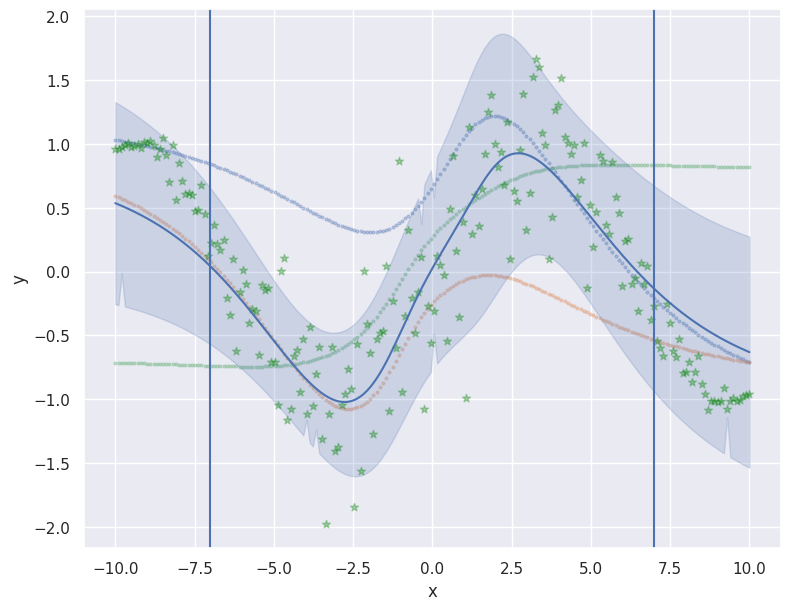

Epoch 30 | batch train loss: 0.04289858043193817 | test loss: 1.260186907190543


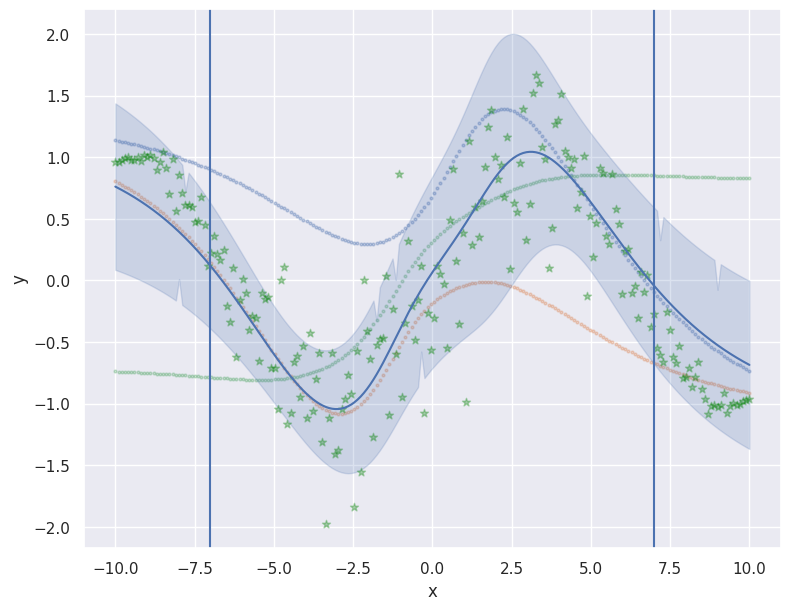

Epoch 40 | batch train loss: -0.5491579174995422 | test loss: 0.8701174855232239


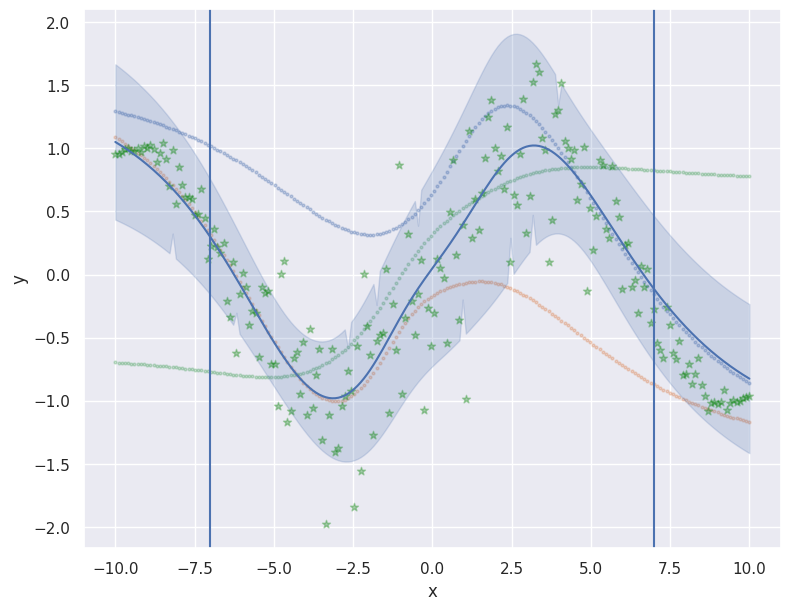

Epoch 50 | batch train loss: -0.5286156535148621 | test loss: 0.5160797487657803


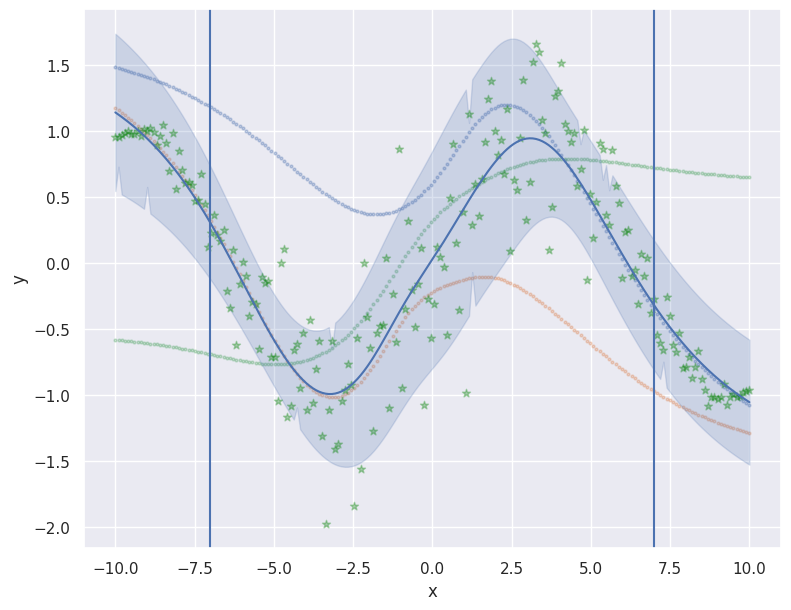

Epoch 60 | batch train loss: -0.4379485547542572 | test loss: 0.8568427585638486


In [ ]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(mdn.parameters(), lr=0.0005)
criterion = mdn_loss
mdn.train()
mdn.to(device)
for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mus, sigmas, alphas = mdn(x)
        loss = criterion(mus, y, sigmas, alphas)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mus, sigmas, alphas = mdn(x)
             all_test_losses.append(criterion(mus, y, sigmas, alphas).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss.item()} | test loss: {test_loss}")
        make_plot_mdn(mdn)

## Quantile Regression
- Some of the implementation details from [here](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a)
- In this case we know that the variance in the variable is normally distributed (and therefore we could optimize the gaussian likelihood). Here we see however that we get a pretty good approximation, even though we don't use the underlying distribution

In [ ]:
class QuantileNet(nn.Module):
    def __init__(self):
        super(QuantileNet, self).__init__()
        hidden_size = 64

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.lower_quantile = nn.Linear(hidden_size, 1)
        self.median = nn.Linear(hidden_size, 1)
        self.upper_quantile = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        lq = self.lower_quantile(h)
        med = self.median(h)
        uq = self.upper_quantile(h)
        return torch.cat([lq, med, uq], axis=1)

qnet = QuantileNet()

In [ ]:
def make_plot_qnet(model):
    preds = model(tensor_x_test)
    preds = preds.detach().numpy()

    dfs = []
    # Lower / Median / Upper
    y_vals = [preds[:, 1], preds[:, 0], preds[:, 2]]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)
    plt.show()

Loss implementation from [here](https://forums.fast.ai/t/quantile-regression-prediction-intervals-confidence-intervals/58821/2).

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

def quantile_loss(preds, target, quantiles=[0.05, 0.5, 0.95]):
    """ aka Pinball loss """
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - torch.unsqueeze(preds[:, i], 1)
        q_loss = torch.max((q-1) * errors, q * errors)
        losses.append(q_loss)
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(qnet.parameters(), lr=0.001)
criterion = quantile_loss
qnet.train()
qnet.to(device)

for epoch in range(100):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        preds = qnet(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             preds = qnet(x)
             all_test_losses.append(criterion(preds, y))
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss.item()} | test loss: {test_loss}")
        make_plot_qnet(qnet)

# Epistemic Uncertainty

```
Before you run this section, please first create the dataset in the first cell
```

## Bayesian Neural Networks

Several choices for BNNs in Pytorch:
- [Blitz](https://github.com/piEsposito/blitz-bayesian-deep-learning)
- [ProbFlow](https://probflow.readthedocs.io/en/latest/)
- [Pyro](https://docs.pyro.ai/en/stable/getting_started.html)
- [Tyxe](https://github.com/karalets/TyXe)
- [Torchbnn](hhttps://github.com/Harry24k/bayesian-neural-network-pytorch)
- and many more...

We will use Blitz in the following, because it has a very straight-forward interface. It currently supports these layers:
*   BayesianModule
*   BayesianLinear
*   BayesianConv1d
*   BayesianConv2d
*   BayesianConv3d
*   BayesianLSTM
*   BayesianGRU
*   BayesianEmbedding

In [ ]:
!pip install blitz-bayesian-pytorch


# A little bit of imports from previous section
import math
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
sns.set(rc={'figure.figsize':(9, 7)})

- The decorator allows to do bayesian-specific operations such as sampling and calculating the variational inference loss.
- Internally, the bayesian layers use for example **TrainableRandomDistribution** to represent trainable distributions over weights.
- TrainableRandomDistribution uses the reparametrization trick for sampling

In [ ]:
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

@variational_estimator
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size = 32

        self.blinear1 = BayesianLinear(1, hidden_size, prior_sigma_1=1)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size, prior_sigma_1=1)
        self.blinear3 = BayesianLinear(hidden_size, 1, prior_sigma_1=1)

    def forward(self, x):
        x_ = torch.relu(self.blinear1(x))
        x_ = torch.relu(self.blinear2(x_))
        return self.blinear3(x_)

bnn = BayesianNetwork()
print(bnn)
print("Params:", sum(p.numel() for p in bnn.parameters() if p.requires_grad))

In [ ]:
def make_plot_bnn(model, samples = 500):
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)

    plt.show()

We will use sample_elbo to sample a loss. This works as follows:
- We sample because we want to approximate the posterior (sampling-based variational inference)
- The loss consists of two parts: KL-Divergence and Likelihood
- KL-Divergence: How close we are to the prior with the current weight distribution (takes the sum)
- Likelihood: Actual loss for regression target e.g. MSE
- For variational inference the weights are sampled several times to gather an approximation for the loss
- In order to get each loss separately we call sample_elbo_detailed_loss
- complexity_cost_weight is the same as the "beta" in beta-VAEs

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(bnn.parameters(), lr=0.01)

bnn.train()
bnn.to(device)
for epoch in range(100):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()

        # See https://arxiv.org/pdf/1505.05424.pdf for complexity cost weight
        loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=0.01/len(train_dataset))

        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=0.01/len(test_dataset))
             all_test_losses.append(loss.item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_bnn(bnn)

## Monte Carlo Dropout

In [ ]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class MCDO(nn.Module):
    def __init__(self):
        super(MCDO, self).__init__()
        hidden_size = 32

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h = self.dropout(torch.relu(self.fc1(x)))
        h = self.dropout(torch.relu(self.fc2(h)))
        out = self.out(h)
        return out

model = MCDO()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

In [ ]:
def make_plot_mcdo(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_train, y_train, c="green", marker="*", alpha=0.1)
    plt.show()

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_mcdo(model)

## Deep Ensembles
-  A deep ensemble, that predicts mean and standard deviation is effectively a Gaussian Mixture Model, because the target variable is assumed to be normally distributed

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 64

        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        var = torch.exp(self.var(h))
        return mu, var

model = SimpleNet()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

In [ ]:
def make_plot_de(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_train, y_train, c="green", marker="*", alpha=0.1)

    plt.show()

In [ ]:
# Construct ensemble
num_models = 5
deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]

In [ ]:
for epoch in range(200):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()

            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_de(deep_ensemble)